In [1]:
library(magrittr)

In [2]:
tran_df = readr::read_tsv('data/matrix/rephetio-v2.0/transformed-features.tsv.bz2') %>%
  dplyr::select(-dplyr::matches('[CD][pt][CD]', ignore.case=F))

Parsed with column specification:
cols(
  .default = col_double(),
  compound_id = col_character(),
  disease_id = col_character(),
  status = col_integer(),
  disease_name = col_character(),
  compound_name = col_character()
)
See spec(...) for full column specifications.


In [3]:
dim(tran_df)

[1] 3075   17

In [4]:
tran_df %>% tail(2)

compound_id,disease_id,status,disease_name,compound_name,prior_logit,degree_CbG,degree_DaG,dwpc_CbGaD,pdwpc_CbGaD,rdwpc_CbGaD,dwpc_CbGaDaGaD,pdwpc_CbGaDaGaD,rdwpc_CbGaDaGaD,dwpc_CbGbCbGaD,pdwpc_CbGbCbGaD,rdwpc_CbGbCbGaD
DB01200,DOID:4989,0,pancreatitis,Bromocriptine,-5.8237,3.8291,5.3279,0.51022,1.0569,-0.54669,1.2623,1.1619,0.10039,1.0433,1.1269,-0.083592
DB08877,DOID:4989,0,pancreatitis,Ruxolitinib,-5.8237,4.4545,5.3279,0.00000,1.2533,-1.25330,1.4684,1.4990,-0.03061,0.2931,1.4884,-1.195300


In [5]:
# auroc_df = readr::read_tsv('data/feature-performance/auroc.tsv') %>%
#   dplyr::filter(! grepl('[CD][pt][CD]', feature))

In [6]:
X_dwpc = tran_df %>%
  dplyr::select(prior_logit, dplyr::starts_with('degree'), dplyr::starts_with('dwpc')) %>%
  as.matrix

X_pdwpc = tran_df %>%
  dplyr::select(prior_logit, dplyr::starts_with('degree'), dplyr::starts_with('pdwpc')) %>%
  as.matrix

X_rdwpc = tran_df %>%
  dplyr::select(prior_logit, dplyr::starts_with('degree'), dplyr::starts_with('rdwpc')) %>%
  as.matrix

X_split = tran_df %>%
  dplyr::select(prior_logit, dplyr::starts_with('degree'), dplyr::starts_with('pdwpc'), dplyr::starts_with('rdwpc')) %>%
  as.matrix

X_all = tran_df %>%
  dplyr::select(prior_logit, dplyr::starts_with('degree'), dplyr::contains('dwpc')) %>%
  as.matrix

dim(X_rdwpc)
dim(X_split)
dim(X_all)

[1] 3075    6

[1] 3075    9

[1] 3075   12

In [7]:
penalty = ifelse(colnames(X_dwpc) == 'prior_logit', 0, 1)
fit_dwpc = hetior::glmnet_train(X_dwpc, tran_df$status, alpha = 0, penalty.factor=penalty, cores=10)
fit_pdwpc = hetior::glmnet_train(X_pdwpc, tran_df$status, alpha = 0, penalty.factor=penalty, cores=10)
fit_rdwpc = hetior::glmnet_train(X_rdwpc, tran_df$status, alpha = 0, penalty.factor=penalty, cores=10)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



In [8]:
penalty = ifelse(colnames(X_split) == 'prior_logit', 0, 1)
fit_split = hetior::glmnet_train(X_split, tran_df$status, alpha = 0, penalty.factor=penalty, cores = 10)

In [9]:
penalty = ifelse(colnames(X_all) == 'prior_logit', 0, 1)
fit_all = hetior::glmnet_train(X_all, tran_df$status, alpha = 0, penalty.factor=penalty, cores = 10)

In [10]:
fit_dwpc$vtm[c('auroc', 'auprc', 'tjur')]
fit_pdwpc$vtm[c('auroc', 'auprc', 'tjur')]
fit_rdwpc$vtm[c('auroc', 'auprc', 'tjur')]

$auroc
[1] 0.8776343

$auprc
[1] 0.6448206

$tjur
[1] 0.3352757

$auroc
[1] 0.8417979

$auprc
[1] 0.5773238

$tjur
[1] 0.2789032

$auroc
[1] 0.8781945

$auprc
[1] 0.6416206

$tjur
[1] 0.3330999

In [11]:
fit_split$vtm[c('auroc', 'auprc', 'tjur')]
fit_all$vtm[c('auroc', 'auprc', 'tjur')]

$auroc
[1] 0.8787517

$auprc
[1] 0.6432377

$tjur
[1] 0.3352901

$auroc
[1] 0.8789705

$auprc
[1] 0.6453894

$tjur
[1] 0.33687

In [12]:
uniform_prior = boot::logit(mean(tran_df$status))
X_dwpc[, 'prior_logit'] = uniform_prior
X_pdwpc[, 'prior_logit'] = uniform_prior
X_rdwpc[, 'prior_logit'] = uniform_prior
X_split[, 'prior_logit'] = uniform_prior
X_all[, 'prior_logit'] = uniform_prior

In [13]:
pred_df = tran_df %>%
  dplyr::mutate(prior = boot::inv.logit(prior_logit)) %>%
  dplyr::select(disease_name, compound_name, status, prior) %>%
  dplyr::mutate(dwpc = hetior::glmnet_predict(fit_dwpc$cv_model, X = X_dwpc)) %>%
  dplyr::mutate(pdwpc = hetior::glmnet_predict(fit_pdwpc$cv_model, X = X_pdwpc)) %>%
  dplyr::mutate(rdwpc = hetior::glmnet_predict(fit_rdwpc$cv_model, X = X_rdwpc)) %>%
  dplyr::mutate(split = hetior::glmnet_predict(fit_split$cv_model, X = X_split)) %>%
  dplyr::mutate(all = hetior::glmnet_predict(fit_all$cv_model, X = X_all))

# pred_df = tran_df %>%
#   dplyr::mutate(prior = boot::inv.logit(prior_logit)) %>%
#   dplyr::select(disease_name, compound_name, status, prior) %>%
#   dplyr::mutate(dwpc = fit_dwpc$y_pred) %>%
#   dplyr::mutate(pdwpc = fit_pdwpc$y_pred) %>%
#   dplyr::mutate(rdwpc = fit_rdwpc$y_pred) %>%
#   dplyr::mutate(split = fit_split$y_pred) %>%
#   dplyr::mutate(all = fit_all$y_pred)

In [14]:
pred_df %>% head(2)

disease_name,compound_name,status,prior,dwpc,pdwpc,rdwpc,split,all
leprosy,Esmolol,0,0.002947929,0.7160729,0.7412801,0.6977072,0.7029718,0.6882234
leprosy,Betaxolol,0,0.002947929,0.7000394,0.7412801,0.7311818,0.7315129,0.7112535


In [15]:
# Pairwise correlations
pred_df %>%
  dplyr::select(prior:all) %>%
  cor() %>%
  round(3) * 100

Warning message in cor(.):
“the standard deviation is zero”

,prior,dwpc,pdwpc,rdwpc,split,all
prior,100.0,17.4,NA,10.1,10.3,14.2
dwpc,17.4,100.0,NA,89.4,90.5,94.7
pdwpc,NA,NA,100,NA,NA,NA
rdwpc,10.1,89.4,NA,100.0,99.9,98.9
split,10.3,90.5,NA,99.9,100.0,99.2
all,14.2,94.7,NA,98.9,99.2,100.0


Joining, by = c("disease_name", "compound_name", "status")


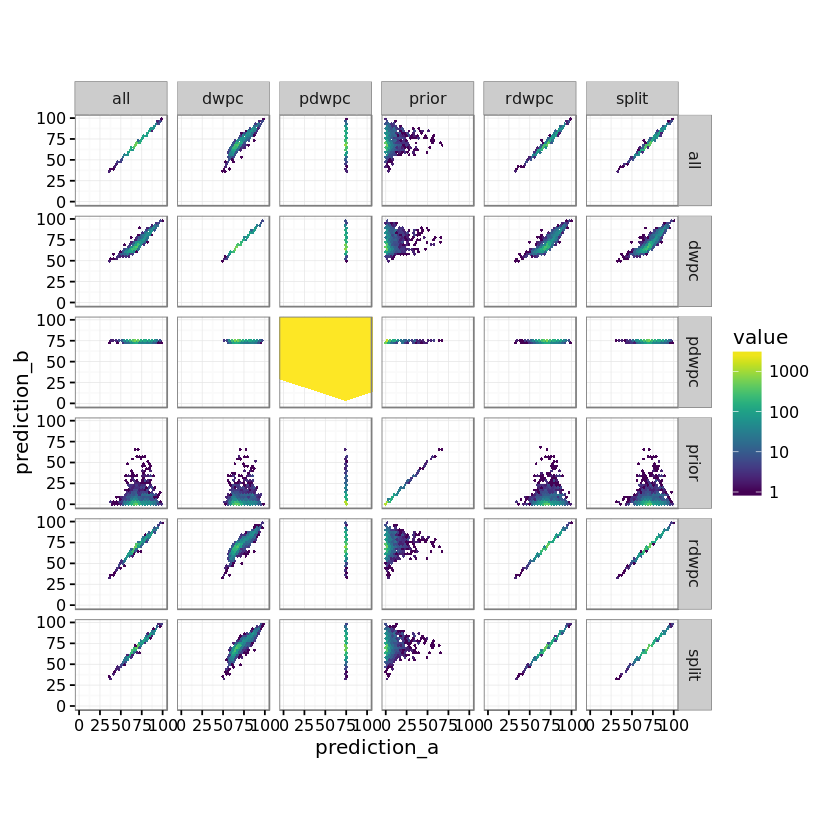

In [16]:
pred_long_df = pred_df %>% 
  tidyr::gather(predictor_set, prediction, prior:all) %>%
  dplyr::mutate(prediction = prediction * 100)

pair_df = dplyr::inner_join(
  pred_long_df %>%
    dplyr::rename(predictor_set_a = predictor_set, prediction_a = prediction),
  pred_long_df %>%
    dplyr::rename(predictor_set_b = predictor_set, prediction_b = prediction)
)

pair_df %>% 
  ggplot2::ggplot(ggplot2::aes(prediction_a, prediction_b)) +
  ggplot2::facet_grid(predictor_set_b ~ predictor_set_a) +
  ggplot2::geom_hex() +
  ggplot2::coord_equal() +
  ggplot2::theme_bw() +
  viridis::scale_fill_viridis(trans = 'log10')

In [17]:
pred_long_df %>%
  dplyr::group_by(predictor_set) %>%
  dplyr::summarize(
      auroc = hetior::calc_vtms(status, prediction, T)$auroc,
      auprc = hetior::calc_vtms(status, prediction, T)$auprc,
      tjur = hetior::calc_vtms(status, prediction, T)$tjur

  )

predictor_set,auroc,auprc,tjur
all,0.7007267,0.4426842,7.048246
dwpc,0.6966303,0.4578664,7.156306
pdwpc,0.5000000,NA,0.000000
prior,0.8417979,0.5773238,7.419053
rdwpc,0.6921955,0.4237696,6.194684
split,0.6926105,0.4243487,6.378089


In [18]:
head(pred_long_df)

disease_name,compound_name,status,predictor_set,prediction
leprosy,Esmolol,0,prior,0.2947929
leprosy,Betaxolol,0,prior,0.2947929
leprosy,Reserpine,0,prior,0.2947929
leprosy,Lovastatin,0,prior,0.6100896
leprosy,Phenytoin,0,prior,0.2947929
leprosy,Carmustine,0,prior,1.6739548


In [19]:
fit_dwpc$coef_df %>%
  dplyr::arrange(zcoef) %>%
  dplyr::filter(abs(zcoef) > 0.1)

feature,coef,zcoef
intercept,3.1438268,-1.9852198
degree_DaG,-0.1640900,-0.1679924
degree_CbG,-0.1192687,-0.1098449
dwpc_CbGbCbGaD,0.2547714,0.1693196
dwpc_CbGaD,0.5374797,0.4484989
prior_logit,1.0386625,1.4696492


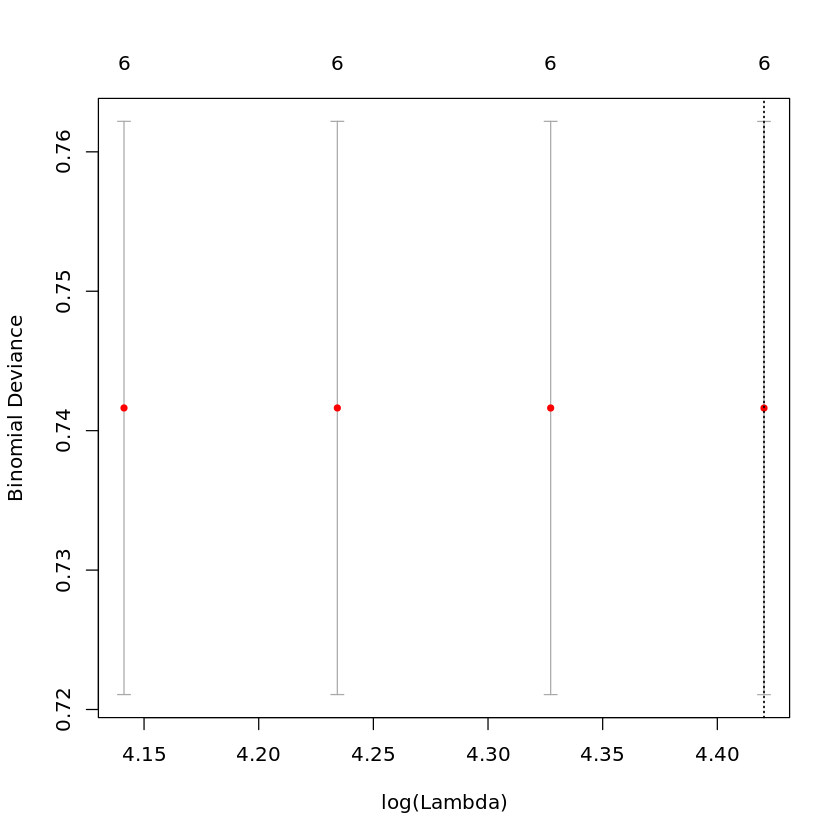

In [20]:
plot(fit_pdwpc$cv_model)

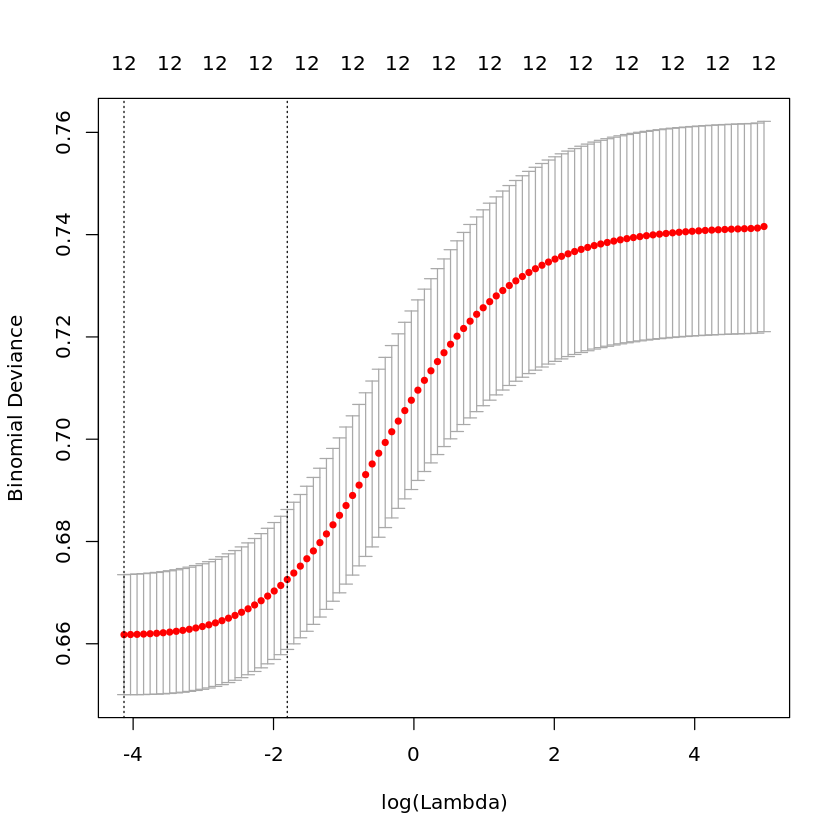

In [21]:
plot(fit_all$cv_model)